**Nikolas Moustakidis**

**AEM: 3743**

**Autoencoder Neural Networks**

Autoencoders are a specific type of feedforward neural networks where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation. The code is a compact “summary” or “compression” of the input, also called the latent-space representation.

An autoencoder consists of 3 components: encoder, code and decoder. The encoder compresses the input and produces the code, the decoder then reconstructs the input only using this code.

Autoencoders are mainly a dimensionality reduction (or compression) algorithm with a couple of important properties:

**Autoencoder Neural Networks Basic Properties:**

1. **Data-specific:** Autoencoders are only able to meaningfully compress data similar to what they have been trained on. Since they learn features specific for the given training data, they are different than a standard data compression algorithm like gzip. So we can’t expect an autoencoder trained on handwritten digits to compress landscape photos.

2. **Lossy:** The output of the autoencoder will not be exactly the same as the input, it will be a close but degraded representation. If you want lossless compression they are not the way to go.

3. **Unsupervised:** To train an autoencoder we don’t need to do anything fancy, just throw the raw input data at it. Autoencoders are considered an unsupervised learning technique since they don’t need explicit labels to train on. But to be more precise they are self-supervised because they generate their own labels from the training data.

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from random import randint

**Downloading the CIFAR-10 dataset and applying augmentations**

The output of torchvision datasets are PILImage images of range [0, 1], so we convert them to pytorch tensors in the range of [0,1] and apply transformations to the training dataset.

We create 2 different datasets:

1. One dataset containing the original images as tensors and normalized in order to feed them to the dimensionality reduction autoencoder.

2. Another dataset containing the original images with the addition of noise in order to feed them to the denoising autoencoder.

In [38]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])


train_transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
    AddGaussianNoise(0., 0.2)
])
test_transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
    AddGaussianNoise(0., 0.2)
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

trainset_noisy = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_noisy)
trainloader_noisy = torch.utils.data.DataLoader(trainset_noisy, batch_size=32,
                                          shuffle=True, num_workers=2)
testset_noisy = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_noisy)
testloader_noisy = torch.utils.data.DataLoader(testset_noisy, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Utils and Helper Functions**

* Train function: Runs the training of the model for the whole train dataset and returns the average loss
* Validate function: Runs the validation of the model for the whole test dataset and returns the average loss
* Plot metrics Function: Plots the losses and accuracies in a figure with subplots

In [31]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def train(model, trainloader, optimizer, criterion, device, idx):
  model.train()
  model.to(device)

  train_loss_avg = 0.0
  for batch_index, batch in enumerate(trainloader):
    x_batch, _ = batch

    x_batch = x_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, x_batch)
    loss.backward()

    optimizer.step()

    train_loss_avg += loss.item()

  train_loss_avg /= (batch_index + 1)

  return  train_loss_avg

def validate(model, testloader, optimizer, criterion, device, idx):
  model.eval()
  model.to(device)

  val_loss_avg = 0.0
  for batch_index, batch in enumerate(testloader):
    x_batch, _ = batch

    x_batch = x_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, x_batch)

    val_loss_avg += loss.item()

  val_loss_avg /= (batch_index + 1)

  return  val_loss_avg

def plot_metrics(index, model_name, train_loss, val_loss):
  axis[index].set_title(f'{model_name}\nTraining Validation Loss')
  axis[index].plot(train_loss,  marker='o', label="Training Loss")
  axis[index].plot(val_loss,  marker='o', label="Validation Loss")
  axis[index].set(xlabel='Epoch', ylabel='Loss')
  axis[index].legend()

**Model architectures**

* **"Deep" Autoencoder with Convolutional Layers:** A convolutional neural network containing 3 layers of encoding and 3 layers of decoding

* **"Shallow" Autoencoder with Convolutional Layers:** A convolutional neural network containing 2 layers of encoding and 2 layers of decoding

In [39]:
class Autoencoder_deep_conv(nn.Module):
  def __init__(self):
    super(Autoencoder_deep_conv,self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)) # output: 128 x 4 x 4

    self.decoder = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2), # output: 128 x 4 x 4

      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2), # output: 64 x 8 x 8

      nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2)) # output: 3 x 32 x 32
      
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class Autoencoder_shallow_conv(nn.Module):
  def __init__(self):
    super(Autoencoder_shallow_conv,self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)) # output: 64 x 8 x 8

    self.decoder = nn.Sequential(
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2), # output: 128 x 4 x 4

      nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2)) # output: 64 x 8 x 8
      
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

**Main training and validation script**

* Train and validate the two models I defined previously in two tasks:


1. **Dimensionality Reduction Autoencoder:** Feed the original images to the autoencoder model and try to reproduce the input as output after compressing the images.

2. **Denoising Autoencoder:** Add noise to the original images and feed them to the autoencoder model and try to reproduce the original images denoised as output after compressing the images.

* Plot the results to compare and select the best one to move on with optimizations

Training model:  autoencoder_deep_conv
Autoencoder_deep_conv(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

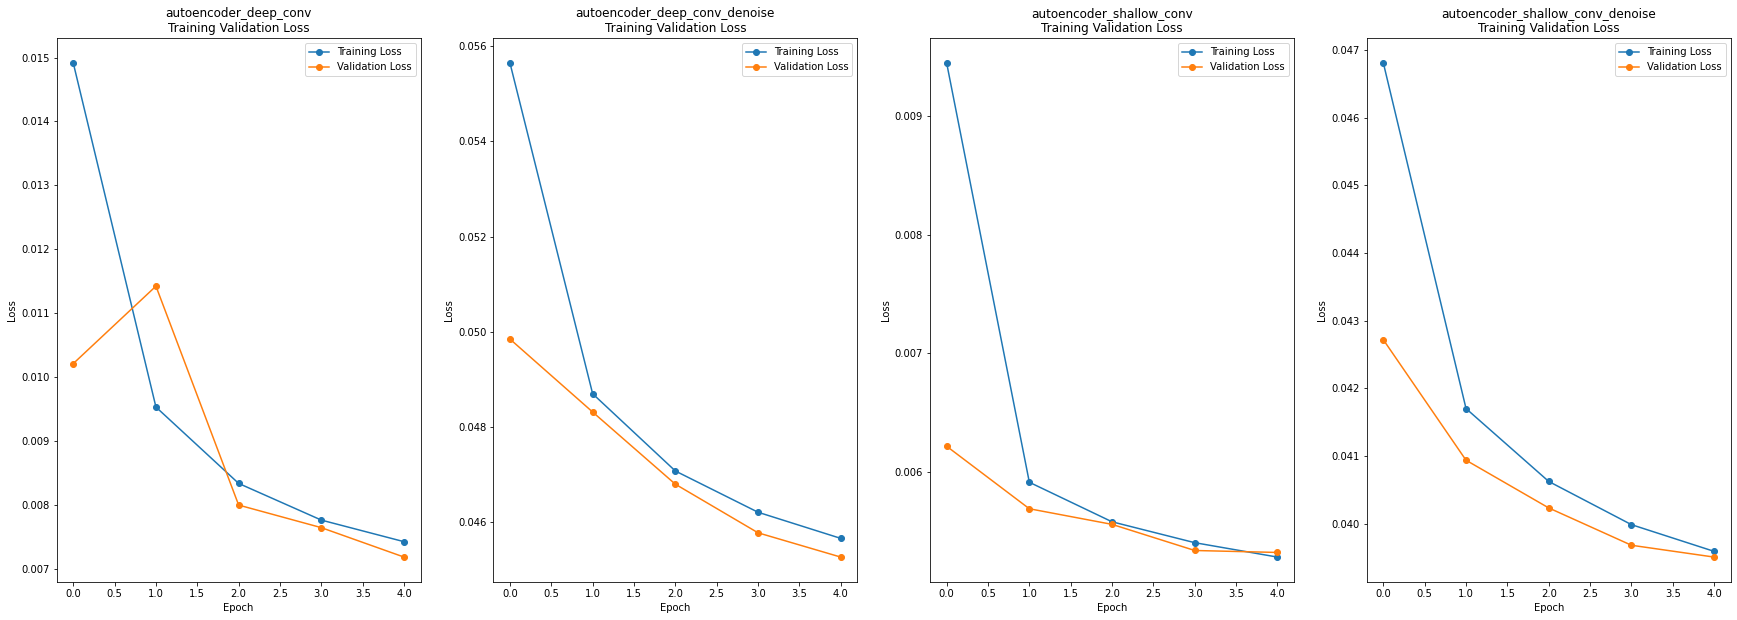

In [40]:
runs = 4
figure, axis = plt.subplots(1, 4, figsize=(30, 10))

for idx in range(runs):
  start = time.time()

  if idx == 0:
    model = Autoencoder_deep_conv()
    model_name = 'autoencoder_deep_conv'
    train_load = trainloader
    test_load = testloader
  elif idx == 1:
    model = Autoencoder_deep_conv()
    model_name = 'autoencoder_deep_conv_denoise'
    train_load = trainloader_noisy
    test_load = testloader_noisy
  elif idx == 2:
    model = Autoencoder_shallow_conv()
    model_name = 'autoencoder_shallow_conv'
    train_load = trainloader
    test_load = testloader
  elif idx == 3:
    model = Autoencoder_shallow_conv()
    model_name = 'autoencoder_shallow_conv_denoise'
    train_load = trainloader_noisy
    test_load = testloader_noisy
  
  print('Training model: ', model_name)
  print(model)

  model_save_path = os.path.join(os.getcwd(), model_name + '.pt')

  epochs = 10
  lr = 1e-3
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
    
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  train_loss_list = []
  val_loss_list = []
  lowest_loss = np.Inf

  for epoch in range(epochs):
    train_loss = train(model, train_load, optimizer, criterion, device, idx)
    train_loss_list.append(train_loss)

    val_loss = validate(model, test_load, optimizer, criterion, device, idx)
    val_loss_list.append(val_loss)

    if val_loss < lowest_loss:
      torch.save(model.state_dict(), model_save_path)

    print('Epoch: {0:3d} | train_loss: {1:2f} | val_loss: {2:2f}'.format(epoch + 1, train_loss, val_loss))

  end = time.time()

  print(f'{model_name} model total training-validation time: {(end-start) / 60} minutes\n')

  plot_metrics(idx, model_name, train_loss_list, val_loss_list)

**Testing the model in a few random samples and visualing the original images compared to the reconstracted and denoised images**

--------------------------------
autoencoder_conv input images



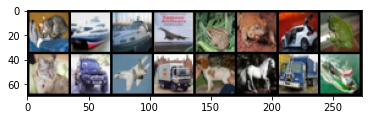

autoencoder_conv output/reconstructed images



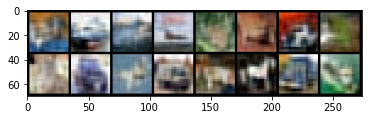

--------------------------------



--------------------------------
autoencoder_conv_denoise input images



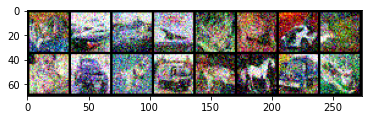

autoencoder_conv_denoise output/reconstructed images



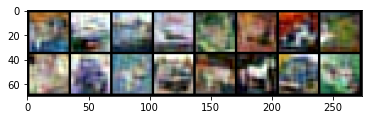

--------------------------------

--------------------------------
autoencoder_conv input images



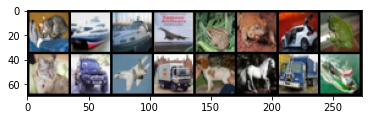

autoencoder_conv output/reconstructed images



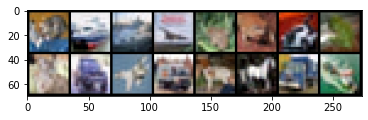

--------------------------------

--------------------------------
autoencoder_conv_denoise input images



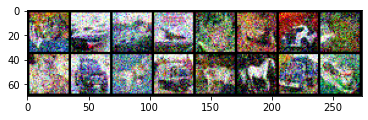

autoencoder_conv_denoise output/reconstructed images



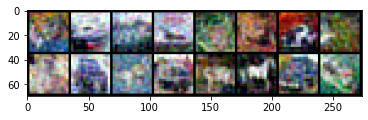

--------------------------------



In [41]:
runs = 4

for idx in range(runs):
  if idx == 0:
    model = Autoencoder_deep_conv()
    model.load_state_dict(torch.load('/content/autoencoder_deep_conv.pt'))
    model_name = 'autoencoder_conv'
    test_load = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)
  elif idx == 1:
    model = Autoencoder_deep_conv()
    model.load_state_dict(torch.load('/content/autoencoder_deep_conv_denoise.pt'))
    model_name = 'autoencoder_conv_denoise'
    test_load = torch.utils.data.DataLoader(testset_noisy, batch_size=16, shuffle=False, num_workers=2)
  elif idx == 2:
    model = Autoencoder_shallow_conv()
    model.load_state_dict(torch.load('/content/autoencoder_shallow_conv.pt'))
    model_name = 'autoencoder_conv'
    test_load = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)
  elif idx == 3:
    model = Autoencoder_shallow_conv()
    model.load_state_dict(torch.load('/content/autoencoder_shallow_conv_denoise.pt'))
    model_name = 'autoencoder_conv_denoise'
    test_load = torch.utils.data.DataLoader(testset_noisy, batch_size=16, shuffle=False, num_workers=2)

  dataiter = iter(test_load)
  images, _ = next(dataiter)

  model.eval()
  model.to(device)

  images = images.to(device)

  # Get predictions from model
  y_pred = model(images)

  print('--------------------------------')
  print(model_name, 'input images\n')

  # Print ground truth images
  imshow(torchvision.utils.make_grid(images.cpu()))

  print(model_name, 'output/reconstructed images\n')

  # Print predicted/reconstructed images
  imshow(torchvision.utils.make_grid(y_pred.cpu()))

  print('--------------------------------\n')

**Final Thoughts:**
As the results show both the dimensionality reduction autoencoders and the denoising autoencoder reconstructed the original images good enough with the expected loss in quality (blurriness).

One thing to point out is that the shallow autoencoder seems to recreate the original images slightly better than the deep autoencoder which reduces the image size to 4x4.

But on the other hand the deep convolutional nn seems to denoise slightly better than the shallow one which makes sense because in the case of denoising the model has to detect meaningful parts in the image and find patterns in order to reconstruct the image appropriately.

Of course the overall performance of the models could be even better if we would train them for more epochs but for this demo I keep the epochs capped at 10 to train faster.